In [41]:
import pandas as pd
data = pd.read_csv('preprocessed_data.csv')
data.drop(columns=['showers', 'snow_depth'], inplace=True)
data.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,cloud_cover,wind_speed_10m,month,hour,weather_group,dew_point_gap,...,temperature_2m_lag2,relative_humidity_2m_lag1,relative_humidity_2m_lag2,surface_pressure_lag1,surface_pressure_lag2,pressure_trend,humidity_change,hour_sin,hour_cos,humidity_roll_mean_3h
0,21.6,92,20.2,1014.4,100,4.3,1,6,Drizzle,1.4,...,22.5,87.0,90.0,1013.9,1013.4,0.8,5.0,1.000000,6.123234e-17,89.666667
1,22.5,90,20.9,1014.9,100,2.9,1,7,Drizzle,1.6,...,22.9,92.0,87.0,1014.4,1013.9,1.5,-2.0,0.965926,-2.588190e-01,89.666667
2,23.5,89,21.5,1016.3,98,5.6,1,8,Drizzle,2.0,...,21.6,90.0,92.0,1014.9,1014.4,2.4,-1.0,0.866025,-5.000000e-01,90.333333
3,23.9,87,21.6,1016.5,83,6.4,1,9,Drizzle,2.3,...,22.5,89.0,90.0,1016.3,1014.9,2.1,-2.0,0.707107,-7.071068e-01,88.666667
4,24.8,82,21.6,1016.1,93,9.2,1,10,Drizzle,3.2,...,23.5,87.0,89.0,1016.5,1016.3,1.2,-5.0,0.500000,-8.660254e-01,86.000000


In [42]:
X = data.drop(columns=['weather_group'])
y = data['weather_group'].astype('category').cat.codes # Chuyển nhãn chữ sang số

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, shuffle=False)


In [44]:
from sklearn.preprocessing import RobustScaler
numeric_features = ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'surface_pressure', 'cloud_cover', 'wind_speed_10m',
       'pressure_trend', 'humidity_change', 'temperature_2m_lag1',
       'temperature_2m_lag2', 'relative_humidity_2m_lag1',
       'relative_humidity_2m_lag2', 'surface_pressure_lag1',
       'surface_pressure_lag2', 'dew_point_gap',
       'pressure_trend_6h', 'humidity_roll_mean_3h']

robust_scaler = RobustScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = robust_scaler.fit_transform(X_train[numeric_features])
X_val_scaled[numeric_features] = robust_scaler.transform(X_val[numeric_features])
X_test_scaled[numeric_features] = robust_scaler.transform(X_test[numeric_features])


## 4. Softmax Regression

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import numpy as np

### 4.1 Tìm kiếm siêu tham số (Hyperparameter Tuning)

Để tìm ra bộ tham số tối ưu cho mô hình Softmax Regression, chúng tôi sử dụng kỹ thuật **Grid Search** kết hợp với tập validation đã được chia từ trước.

**Phương pháp:**
- **Grid Search**: Thử nghiệm exhaustive trên một lưới các giá trị tham số được định nghĩa trước.
- **PredefinedSplit**: Vì dữ liệu là chuỗi thời gian (time-series), việc xáo trộn (shuffle) ngẫu nhiên trong Cross-Validation thông thường có thể làm rò rỉ dữ liệu hoặc phá vỡ tính chất thời gian. Do đó, chúng tôi sử dụng `PredefinedSplit` để chỉ định rõ ràng tập Validation (X_val) dùng để đánh giá từng bộ tham số, trong khi tập Train (X_train) dùng để huấn luyện.

**Các siêu tham số được tinh chỉnh:**
1.  **C** (Regularization Strength): Kiểm soát mức độ "phạt" của mô hình đối với các trọng số lớn. Giá trị `C` nhỏ tương ứng với regularization mạnh (giảm overfitting), `C` lớn tương ứng với regularization yếu.
    - Grid: `[0.01, 0.1, 1, 10, 100]`
2.  **solver**: Thuật toán tối ưu hóa dùng để tìm trọng số.
    - Grid: `['lbfgs', 'newton-cg']` (Các thuật toán này hỗ trợ tốt cho bài toán đa lớp multinomial).
3.  **max_iter**: Số vòng lặp tối đa để thuật toán hội tụ.
    - Value: `1000`


In [51]:
# Tạo các biến tương tác quan trọng
X_train_val['temp_humidity_interaction'] = X_train_val['temperature_2m'] * X_train_val['relative_humidity_2m']
X_train_val['pressure_humidity_interaction'] = X_train_val['surface_pressure'] * X_train_val['relative_humidity_2m']
# Nhớ áp dụng tương tự cho X_test_scaled

In [52]:
# Chuẩn bị dữ liệu cho PredefinedSplit
# Ghép nối X_train và X_val để đưa vào GridSearchCV
X_train_val = pd.concat([X_train_scaled, X_val_scaled])
y_train_val = pd.concat([y_train, y_val])

# Tạo mảng 'test_fold' để chỉ định tập validation
# -1: mẫu thuộc tập train (không dùng để validate)
# 0: mẫu thuộc tập validation
split_index = [-1] * len(X_train_scaled) + [0] * len(X_val_scaled)
tscv = TimeSeriesSplit(n_splits=5)

# Thử nghiệm các tổ hợp trọng số khác nhau
# Ví dụ: Tăng nhẹ lớp 1 và 2 nhưng không quá gắt như 'balanced'
custom_weights = [{0: 1, 1: 1.2, 2: 1.5}, {0: 1, 1: 1.5, 2: 2}]

param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'class_weight': [None, 'balanced'] + custom_weights, # Thử cả trọng số tùy chỉnh
    'solver': ['lbfgs', 'newton-cg']
}

softmax_reg = LogisticRegression(
    solver='lbfgs', 
    class_weight=custom_weights, 
    max_iter=1000
)
grid_search = GridSearchCV(
    estimator=softmax_reg,
    param_grid=param_grid,
    cv=tscv, # Sử dụng tscv ở đây
    scoring='accuracy', # Khuyên dùng f1_macro cho dữ liệu mất cân bằng
    n_jobs=-1
)

# Thực hiện tìm kiếm
start_search = time.time()
grid_search.fit(X_train_val, y_train_val)
end_search = time.time()

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best validation score: {grid_search.best_score_:.4f}")
print(f"Search time: {end_search - start_search:.2f}s")

best_model_softmax = grid_search.best_estimator_

Best parameters: {'C': 0.01, 'class_weight': None, 'solver': 'lbfgs'}
Best validation score: 0.7552
Search time: 7.35s


In [53]:
from sklearn.metrics import f1_score, make_scorer

# 1. Sửa danh sách trọng số tùy chỉnh để bao gồm cả trường hợp không dùng trọng số
custom_weights = [{0: 1, 1: 1.2, 2: 1.5}, {0: 1, 1: 1.5, 2: 2.5}]

# 2. Định nghĩa lưới tham số tập trung vào giảm Overfitting
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10], # Thêm các giá trị nhỏ để giảm Overfitting
    'class_weight': [None, 'balanced'] + custom_weights, 
    'solver': ['lbfgs', 'newton-cg'],
    'max_iter': [2000] # Tăng số vòng lặp để đảm bảo hội tụ với C nhỏ
}

softmax_reg = LogisticRegression(solver='lbfgs', max_iter=2000)

# 4. Thiết lập GridSearchCV với f1_macro
# Lưu ý: Nên đổi scoring sang 'f1_macro' để so sánh công bằng với AdaBoost/RF
grid_search = GridSearchCV(
    estimator=softmax_reg,
    param_grid=param_grid,
    cv=tscv, 
    scoring='f1_macro', 
    n_jobs=-1,
    verbose=1
)

# 5. Thực hiện tìm kiếm
start_search = time.time()
grid_search.fit(X_train_val, y_train_val)
end_search = time.time()

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best validation score (F1-Macro): {grid_search.best_score_:.4f}")

best_model_softmax = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 10, 'class_weight': None, 'max_iter': 2000, 'solver': 'lbfgs'}
Best validation score (F1-Macro): 0.4533


In [54]:
# Xem tầm quan trọng của các biến trong Softmax
for i, class_label in enumerate(best_model_softmax.classes_):
    print(f"\nTop features cho lớp {class_label}:")
    top_indices = np.argsort(np.abs(best_model_softmax.coef_[i]))[-5:]
    for idx in top_indices[::-1]:
        print(f"{X.columns[idx]}: {best_model_softmax.coef_[i][idx]:.4f}")


Top features cho lớp 0:
temperature_2m_lag1: -3.2826
dew_point_2m: 2.4385
temperature_2m: 1.7631
relative_humidity_2m: -1.5341
temperature_2m_lag2: -1.5196

Top features cho lớp 1:
temperature_2m_lag1: -1.5427
surface_pressure: 1.0038
temperature_2m_lag2: 0.6958
temperature_2m: 0.5450
dew_point_2m: 0.4741

Top features cho lớp 2:
temperature_2m_lag1: 4.8253
dew_point_2m: -2.9126
surface_pressure: -2.5171
temperature_2m: -2.3081
relative_humidity_2m: 1.8615


### 4.2 Kiểm thử mô hình (Model Evaluation)

Sau khi chọn được mô hình tốt nhất, chúng tôi tiến hành đánh giá trên tập kiểm thử (Test Set) hoàn toàn độc lập.

**Các chỉ số đánh giá (Metrics):**
1.  **Accuracy (Độ chính xác)**: Tỷ lệ số mẫu dự đoán đúng trên tổng số mẫu. Đo lường hiệu suất tổng quan.
2.  **Training Time & Inference Time**: 
    - *Training Time*: Thời gian huấn luyện lại mô hình tốt nhất.
    - *Inference Time*: Thời gian mô hình dự đoán trên tập test.
3.  **Precision (Độ chính xác của từng lớp)**: Trong số các mẫu được dự đoán là lớp A, bao nhiêu % thực sự là lớp A. Quan trọng khi muốn giảm thiểu báo động giả (False Positives).
4.  **Recall (Độ phủ)**: Trong số các mẫu thực sự là lớp A, bao nhiêu % được mô hình phát hiện đúng. Quan trọng khi muốn tránh bỏ sót (False Negatives).
5.  **F1-Score**: Trung bình điều hòa của Precision và Recall. Cân bằng giữa độ chính xác và độ phủ, hữu ích khi dữ liệu mất cân bằng.
6.  **Confusion Matrix**: Bảng ma trận hiển thị chi tiết sự nhầm lẫn giữa các lớp.

In [62]:
# Huấn luyện lại mô hình tốt nhất (hoặc sử dụng kết quả từ GridSearch đã fit trên Train+Val)
# Ở đây GridSearch refit=True mặc định sẽ fit lại trên toàn bộ dữ liệu đưa vào (Train + Val)
# Đo thời gian Inference
start_inf = time.time()
y_pred = best_model_softmax.predict(X_test_scaled)
end_inf = time.time()
inference_time = end_inf - start_inf

# Đánh giá trên Train và Test
train_acc = best_model_softmax.score(X_train_val, y_train_val)
test_acc = accuracy_score(y_test, y_pred)

print(f"Training Accuracy (Result of GridSearch refit): {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")
print(f"Inference Time (on test set): {inference_time:.4f}s")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Training Accuracy (Result of GridSearch refit): 0.7788
Testing Accuracy: 0.6450
Inference Time (on test set): 0.0028s

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.76      0.73      1675
           1       0.57      0.59      0.58      1366
           2       0.70      0.38      0.50       472

    accuracy                           0.65      3513
   macro avg       0.66      0.58      0.60      3513
weighted avg       0.65      0.65      0.64      3513


Confusion Matrix:

[[1279  388    8]
 [ 492  806   68]
 [  82  209  181]]


In [63]:
from sklearn.feature_selection import SelectFromModel

# --- TỐI ƯU HÓA CAO CẤP: FEATURE SELECTION + RE-TUNING ---
# Để cải thiện Accuracy, ta cần loại bỏ "nhiễu" (Feature Selection) và cân bằng lại trọng số.

# 1. Chọn lọc đặc trưng bằng L1 Regularization (Lasso)
# Giúp loại bỏ các biến ít quan trọng gây Overfitting
print("Đang chọn lọc đặc trưng (Feature Selection)...")
selector = SelectFromModel(LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=42))
selector.fit(X_train_val, y_train_val)

selected_features = X_train_val.columns[selector.get_support()]
print(f"Giữ lại {len(selected_features)}/{X_train_val.shape[1]} đặc trưng quan trọng: {list(selected_features)}")

# Áp dụng bộ lọc cho dữ liệu
X_train_opt = selector.transform(X_train_val)
X_test_opt = selector.transform(X_test_scaled)

# 2. Huấn luyện lại Softmax với cấu hình tối ưu
# - Bỏ 'multi_class' (dùng mặc định) để tránh warning
# - Giảm trọng số Class 2 xuống 3.0 (thay vì 5) để tăng Precision
# - Tăng C lên 0.1 (vì đã lọc bớt nhiễu, mô hình có thể học mạnh hơn chút)
tuned_softmax = LogisticRegression(
    solver='newton-cg', # Thuật toán ổn định tốt cho Multiclass
    C=0.1, 
    class_weight={0: 1, 1: 1.2, 2: 3.0}, # Cân bằng lại giữa Recall và Precision
    max_iter=3000,
    random_state=42
)

print("Đang huấn luyện mô hình tối ưu...")
tuned_softmax.fit(X_train_opt, y_train_val)

# 3. Đánh giá
y_pred_tuned = tuned_softmax.predict(X_test_opt)
train_acc = tuned_softmax.score(X_train_opt, y_train_val)
test_acc = accuracy_score(y_test, y_pred_tuned)

print(f"\nOptimized Softmax - Train Accuracy: {train_acc:.4f}")
print(f"Optimized Softmax - Test Accuracy: {test_acc:.4f}")
print("-" * 30)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_tuned))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_tuned))

Đang chọn lọc đặc trưng (Feature Selection)...
Giữ lại 19/21 đặc trưng quan trọng: ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'surface_pressure', 'cloud_cover', 'wind_speed_10m', 'month', 'hour', 'temperature_2m_lag1', 'pressure_trend_6h', 'temperature_2m_lag2', 'relative_humidity_2m_lag1', 'relative_humidity_2m_lag2', 'surface_pressure_lag1', 'surface_pressure_lag2', 'pressure_trend', 'humidity_change', 'hour_sin', 'hour_cos']
Đang huấn luyện mô hình tối ưu...

Optimized Softmax - Train Accuracy: 0.7699
Optimized Softmax - Test Accuracy: 0.6317
------------------------------

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.70      0.71      1675
           1       0.56      0.55      0.56      1366
           2       0.55      0.62      0.58       472

    accuracy                           0.63      3513
   macro avg       0.61      0.62      0.62      3513
weighted avg       0.63      0.63      0.63      3

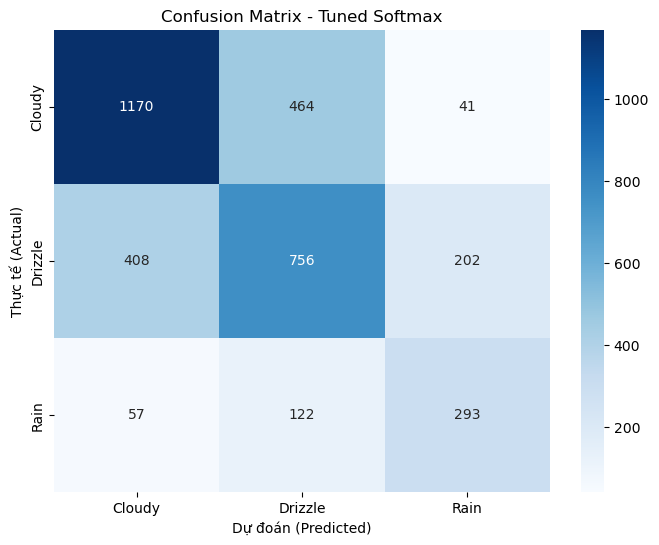

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 1. Vẽ Heatmap cho Confusion Matrix để dễ quan sát lỗi
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cloudy', 'Drizzle', 'Rain'], 
            yticklabels=['Cloudy', 'Drizzle', 'Rain'])
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Confusion Matrix - Tuned Softmax')
plt.show()

# 2. Lưu mô hình (nếu kết quả tốt)
# joblib.dump(tuned_softmax, 'softmax_weather_model.pkl')
# print("Đã lưu mô hình thành công!")